## Bitcoin Trading: enhancing speed and accuracy

Using dimensionality reduction techniques, we can compress many features and technical indicators into a few logical collections, while still maintaining a significant amount of the variance of the original data. This helps speed up model training and tuning. Additionally, it helps prevent overfitting by getting rid of correlated variables, which can ultimately cause more harm than good.

We will follow the same steps as the previous [bitcoin trading strategy](https://github.com/alecontuIT/ml_for_finance/blob/main/supervised%20learning%20(classification)/3_Bitcoin_trading_strategy.ipynb) but we will **apply dimensionality reduction techniques on the  technical indicator features** (trend, volume, volatility, and momentum) **to enhance an algorithmic trading strategy**.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download data from Yahoo Finance
dataset = yf.download('BTC-EUR', period='max', interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

### Data preparation
#### Data cleaning

In [3]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


#### Preparing data for classification

We attach a label to each movement:

- 1 if the signal is that short term price will go up as compared to the long term.
- 0 if the signal is that short term price will go down as compared to the long term.

In [5]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

#### Feature engineering

FE is the task of identifing and constructing new features given raw data. In this case we compute some momentum indicators.
The current data of the bicoin consists of date, open, high, low, close and volume. Using this data we calculate the following technical indicators:

- **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
- **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
- **Relative Strength Index (RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
- **Rate Of Change (ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
- **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.


In [7]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)


#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [10]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-17,63719.652344,64319.992188,59503.882812,59975.605469,59975.605469,43012848654,63662.512891,48420.054753,1.0,62768.734598,...,60.123810,5.961657,50.988374,64.123691,79.291685,83.174450,90.246324,63662.512891,56263.282943,37170.905029
2024-03-18,59976.734375,63235.273438,59223.554688,62838.261719,62838.261719,41086480972,63834.998437,48812.976237,1.0,62781.375893,...,61.009269,44.119793,37.099737,77.926016,74.758435,89.647572,88.162015,63834.998437,56744.559245,37360.218447
2024-03-19,62820.515625,63275.128906,61246.179688,62122.750000,62122.750000,45304643119,63806.119922,49216.376758,1.0,62661.625731,...,60.670846,35.386518,28.489323,74.476169,72.175292,88.029636,86.950553,63806.119922,57217.363932,37551.248428
2024-03-20,62129.683594,62630.515625,56642.945312,56999.375000,56999.375000,68326075351,63246.739062,49530.263672,1.0,61632.125598,...,58.341895,3.308378,27.604896,49.773766,67.391984,76.444511,84.707240,63246.739062,57506.221354,37716.659072
2024-03-21,62063.371094,62270.113281,60559.062500,61379.453125,61379.453125,53476532224,63077.387109,49916.430794,1.0,61586.185148,...,59.672011,43.964238,27.553045,70.892356,65.047430,86.348872,83.607673,63077.387109,57950.489583,37903.654590


In [11]:
# Excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

In [12]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [13]:
dataset = dataset.dropna(axis=0)

#### Data visualization

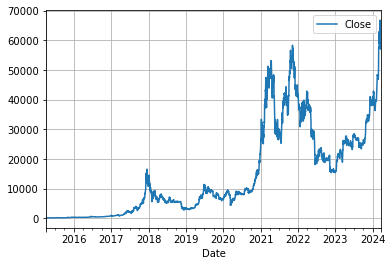

In [17]:
import matplotlib.pyplot as plt
dataset[['Close']].plot(grid=True)
plt.show()

signal
0.0    42.071494
1.0    57.928506
dtype: float64


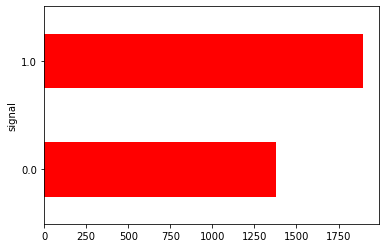

In [26]:
print(dataset.groupby(['signal']).size()/dataset.groupby(['signal']).size().sum()*100)
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

The predicted variable is upward 57.92% out of total data-size, meaning that number of the buy signals was higher than that of sell signals.

### Evaluate algorithms and models

In [27]:
from sklearn.model_selection import train_test_split
# Train-test split
Y= dataset["signal"]
X = dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

We standardize the variables on the same scale before applying dimensionality reduction. 

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)

### Singular Valure Decomposition (for feature reduction)

We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible.

Hence, we use a technique called singular value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. We are using the TruncatedSVD method in the sklearn package.

Variance preserved by first 5 components == 93.10%


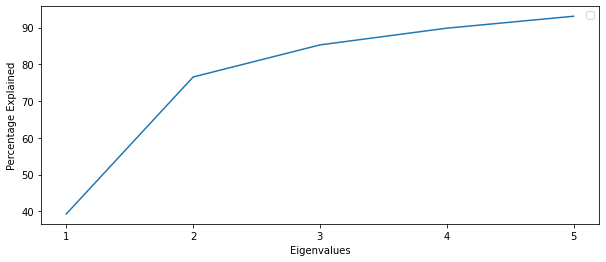

In [30]:
from sklearn.decomposition import TruncatedSVD
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

We can preserve 92.75% variance by using just 5 components rather than the full 25+ original features.

In [31]:
# Dataframe made of the 5 components only as features
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
dfsvd.head()

,c0,c1,c2,c3,c4
Date,,,,,
2015-08-26,-3.712703,-2.576050,0.544065,-0.922976,-0.468779
2022-05-09,-6.827852,4.038064,-0.419841,1.608131,1.761754
2020-01-21,0.898345,-1.332501,1.213192,-0.560280,0.968082
2021-06-04,-3.469163,3.465307,0.851096,3.435432,-0.602367
2021-06-20,-1.712179,3.526787,0.299847,-0.230052,0.440543


### Visualization of the reduced features
Now we attempt to visualise the data with the compressed dataset, represented by the top 5 components of an SVD.

#### Pairs Plots
Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).

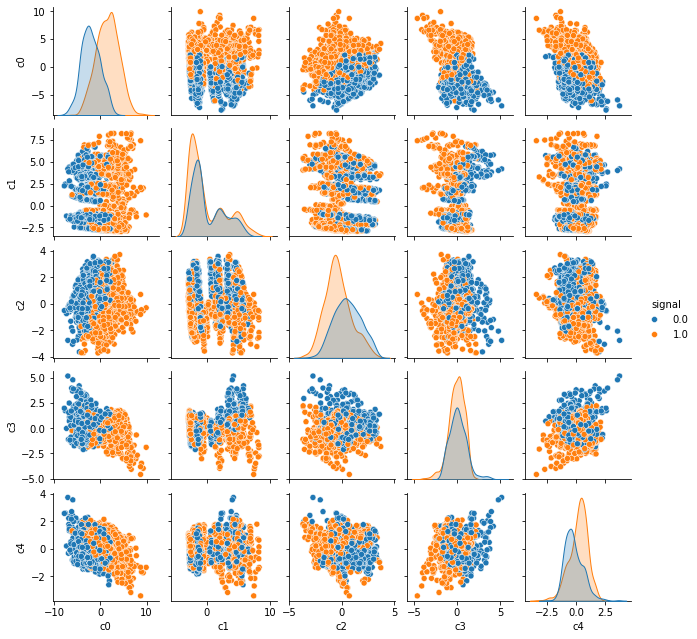

In [32]:
import seaborn as sns
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

In the scatter plot of each of the principal component, we can clearly that there is a clear segregation of the orange and blue dots, which means that data-points from the same type of signal tend to cluster together.

#### 3D Scatterplot
As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

In [70]:
from ipywidgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')
    fig.add_axes(ax)
    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

    
dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

We can use these controls to interactively change the view of the top 3 components and investigate their relations. This certainly appears to be more informative than pairs-plots.

However, we still suffer from the same major limitations of the pairs-plots, namely that we lose a lot of the variance and have to hold a lot in our heads when viewing.

#### t-SNE visualization
In this step, we implement another technique of dimensionality reduction t-SNE and look at the related visualization.

Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

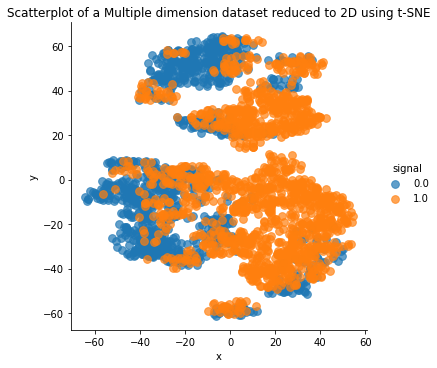

In [78]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

dftsne['signal'] = Y_train

g = sns.lmplot(dftsne, x='x', y='y', hue='signal', fit_reg=False, scatter_kws={'alpha':0.7,'s':60}, x_jitter=8)
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

Observation:

This is quite interesting way of visualizing the trading signal data. The above plot shows us that there is a good degree of clustering for the trading signal. Although, there are some overap of the long and short signals, but they can be distinguished quite well using the reduced number of features.

In Review:

We have analyzed the bitcoin trading signal dataset in the following steps:

- We prepared the data by cleaning (removing character features values, replacing nans) and normalizing.
- We applied transformation during the feature reduction stage.
- We then visualized the data in the reduced dimentionality and ultimately applied t-SNE algorithm to reduce the data into two dimensions and visualize effectivly

### Compare Models with and without dimensionality Reduction

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()

# test options for classification
scoring = 'accuracy'
kfold=10
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 2.542881965637207 seconds ---


In [83]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 1.0540931224822998 seconds ---


In [84]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.957597 (0.006523)
Result with dimensionality Reduction: 0.918258 (0.012099)


Looking at the model results, we do not deviate that much from the accuracy, and the accuracy just decreases from 95.7% to 91.8%. However, there is an improvement in the time taken.

Thus, in trading strategy development, **when the datasets are huge and the number of features is big such improvement in time can lead to a significant improvement in the entire process**.

**Whether the loss in accuracy is acceptable likely depends on the problem**. If this is a model that needs to be recalibrated very frequently, then a lower computation time will be essential, especially when handling large, high-velocity datasets. The improvement in the computation time does have other benefits, especially in the early stages of trading strategy development. It enables us to test a greater number of features (or technical indicators) in less time.